In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


pd.set_option("display.max_colwidth", 200)


In [3]:
df = pd.read_csv(r"/content/drive/MyDrive/phishing_email.csv")
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls,0
1,nom actual vols 24 th forwarded sabrae zajac hou ect 05 30 2001 12 07 pm enron capital trade resources corp eileen ponton 05 29 2001 08 37 davilal txu com cstonel txu com mjones 7 txu com hpl sche...,0
2,enron actuals march 30 april 1 201 estimated actuals march 30 2001 flow march 31 2001 flow april 1 2001 teco tap 35 000 receive actuals duke forward,0
3,hpl nom may 30 2001 see attached file hplno 530 xls hplno 530 xls,0
4,hpl nom june 1 2001 see attached file hplno 601 xls hplno 601 xls,0


In [4]:
df['label'].value_counts()
df["label"].value_counts(normalize=True)


,proportion
label,
1,0.519979
0,0.480021


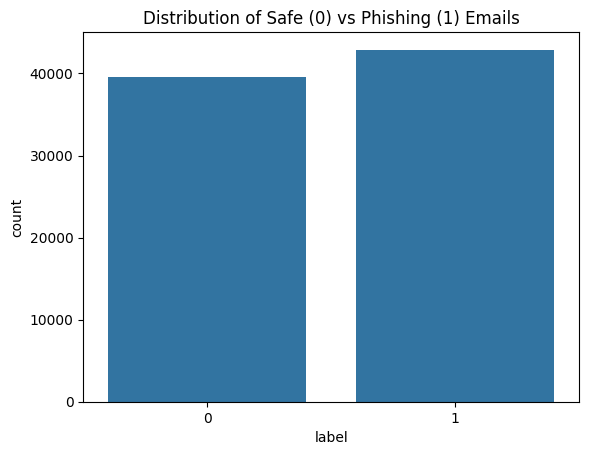

In [5]:
# Visualize label distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Safe (0) vs Phishing (1) Emails')
plt.show()

In [6]:
df.shape

(82486, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
df[df["label"] == 0]["text_combined"].sample(1, random_state=1).iloc[0][:500]


'fw first cut canada data hi savita attached ugly first cut data canada sheets jumble information jist canada lot activity nit term physical products peak may julyo 0 period low novo 0 janol period 3000 trades vs 1550 trades significant product offering difference two periods gd sumas product offered may july nov jan accounts relatively trades enron north america higher percentage trading canadian gas products novo 0 janol earlier months handful counterparties murphy oil dynegy marketing conducte'

In [9]:
# text length
df["text_length"] = df["text_combined"].apply(len)


In [10]:
df.groupby("label")["text_length"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,39595.0,1536.096098,3695.897909,11.0,411.0,779.0,1493.0,160318.0
1,42891.0,1060.413793,21192.696303,1.0,241.0,391.0,1058.0,4279526.0


In [11]:
# manually checking the  urgency language.

urgency_words = ["urgent", "immediately", "act now", "verify", "click", "limited"]

def contains_urgency(text):
    text = text.lower()
    return any(word in text for word in urgency_words)

df["has_urgency"] = df["text_combined"].apply(contains_urgency)


In [12]:
df.head()

,text_combined,label,text_length,has_urgency
0,hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls,0,65,False
1,nom actual vols 24 th forwarded sabrae zajac hou ect 05 30 2001 12 07 pm enron capital trade resources corp eileen ponton 05 29 2001 08 37 davilal txu com cstonel txu com mjones 7 txu com hpl sche...,0,1071,False
2,enron actuals march 30 april 1 201 estimated actuals march 30 2001 flow march 31 2001 flow april 1 2001 teco tap 35 000 receive actuals duke forward,0,148,False
3,hpl nom may 30 2001 see attached file hplno 530 xls hplno 530 xls,0,65,False
4,hpl nom june 1 2001 see attached file hplno 601 xls hplno 601 xls,0,65,False


In [13]:
pd.crosstab(df["has_urgency"], df["label"], normalize="columns")


label,0,1
has_urgency,,
False,0.855916,0.73442
True,0.144084,0.26558




-  As see above phishing emails contain urgency language much more often

In [14]:
# checking null values
df.isnull().sum()

,0
text_combined,0
label,0
text_length,0
has_urgency,0


In [15]:
df["clean_text"] = (
    df["text_combined"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.replace(r"[^a-z0-9\s:/\.]", "", regex=True)
)

In [16]:
df_1 = df[['clean_text', 'label']]  # keep only required columns
df_1

,clean_text,label
0,hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls,0
1,nom actual vols 24 th forwarded sabrae zajac hou ect 05 30 2001 12 07 pm enron capital trade resources corp eileen ponton 05 29 2001 08 37 davilal txu com cstonel txu com mjones 7 txu com hpl sche...,0
2,enron actuals march 30 april 1 201 estimated actuals march 30 2001 flow march 31 2001 flow april 1 2001 teco tap 35 000 receive actuals duke forward,0
3,hpl nom may 30 2001 see attached file hplno 530 xls hplno 530 xls,0
4,hpl nom june 1 2001 see attached file hplno 601 xls hplno 601 xls,0
...,...,...
82481,info advantageapartmentscom infoadvantageapartmentscom paypal sent payment 69999 usd ftx may take moments transaction appear account transaction id 9xj31677tk080711f transaction date dec 11 2022 m...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josepassword josemonkeyorg expire todayuse current password continue josemonkeyorg keep password 15 dec 2022 183300 0500 rectify password monkeyorg,1
82483,help center infohelpcentercozainfohelpcentercozainfohelpcentercoza177005em5269xfund02ml hello please note monthly payment failed billing team cant debit nominated card due missing information paym...,1
82484,metamask infosofamekarcom verify metamask wallet system shown metamask wallet yet verified verification done easily via button unverified accounts suspended friday 13 january 2023 sorry inconvenie...,1


In [17]:
#drop duplicates
df_1.drop_duplicates(inplace=True)


/tmp/ipython-input-2850557191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop_duplicates(inplace=True)


In [18]:
df_1.head()

,clean_text,label
0,hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls,0
1,nom actual vols 24 th forwarded sabrae zajac hou ect 05 30 2001 12 07 pm enron capital trade resources corp eileen ponton 05 29 2001 08 37 davilal txu com cstonel txu com mjones 7 txu com hpl sche...,0
2,enron actuals march 30 april 1 201 estimated actuals march 30 2001 flow march 31 2001 flow april 1 2001 teco tap 35 000 receive actuals duke forward,0
3,hpl nom may 30 2001 see attached file hplno 530 xls hplno 530 xls,0
4,hpl nom june 1 2001 see attached file hplno 601 xls hplno 601 xls,0


## Define TF-IDF vectorizer

In [19]:
tfidf = TfidfVectorizer(
    lowercase=True,          # lowercase text
    stop_words=None,         # keep phishing-related words
    ngram_range=(1, 2),      # unigrams + bigrams
    max_features=10000       # limit features for memory efficiency
)


## Fit TF-IDF and transform data

In [20]:
X = tfidf.fit_transform(df_1['clean_text']) # feature
y = df_1['label']                              # target col

print("TF-IDF shape:", X.shape)


TF-IDF shape: (82076, 10000)


## Split into train + temp (val + test)

In [21]:
from sklearn.model_selection import train_test_split

# First split: train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


## Split temp into validation + test

In [22]:
# Now split temp equally for validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [23]:
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Training set: (57453, 10000)
Validation set: (12311, 10000)
Test set: (12312, 10000)


## Train the Random Forest Classifier (Model building)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=10 | Train Acc: 0.9152, Val Acc: 0.9082 | Train F1: 0.9205, Val F1: 0.9141


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=20 | Train Acc: 0.9375, Val Acc: 0.9301 | Train F1: 0.9409, Val F1: 0.9339


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=30 | Train Acc: 0.9432, Val Acc: 0.9371 | Train F1: 0.9460, Val F1: 0.9404


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=40 | Train Acc: 0.9476, Val Acc: 0.9408 | Train F1: 0.9503, Val F1: 0.9439


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=50 | Train Acc: 0.9499, Val Acc: 0.9417 | Train F1: 0.9524, Val F1: 0.9446


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=60 | Train Acc: 0.9499, Val Acc: 0.9428 | Train F1: 0.9524, Val F1: 0.9457


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=70 | Train Acc: 0.9504, Val Acc: 0.9443 | Train F1: 0.9529, Val F1: 0.9470


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=80 | Train Acc: 0.9502, Val Acc: 0.9438 | Train F1: 0.9528, Val F1: 0.9467


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=90 | Train Acc: 0.9498, Val Acc: 0.9434 | Train F1: 0.9525, Val F1: 0.9464


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=100 | Train Acc: 0.9508, Val Acc: 0.9432 | Train F1: 0.9533, Val F1: 0.9461


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=110 | Train Acc: 0.9509, Val Acc: 0.9436 | Train F1: 0.9534, Val F1: 0.9465


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=120 | Train Acc: 0.9514, Val Acc: 0.9445 | Train F1: 0.9539, Val F1: 0.9474


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=130 | Train Acc: 0.9511, Val Acc: 0.9444 | Train F1: 0.9537, Val F1: 0.9472


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=140 | Train Acc: 0.9513, Val Acc: 0.9440 | Train F1: 0.9539, Val F1: 0.9469


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=150 | Train Acc: 0.9514, Val Acc: 0.9446 | Train F1: 0.9540, Val F1: 0.9476


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=160 | Train Acc: 0.9523, Val Acc: 0.9453 | Train F1: 0.9549, Val F1: 0.9481


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=170 | Train Acc: 0.9520, Val Acc: 0.9452 | Train F1: 0.9546, Val F1: 0.9481


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=180 | Train Acc: 0.9521, Val Acc: 0.9451 | Train F1: 0.9548, Val F1: 0.9480


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=190 | Train Acc: 0.9516, Val Acc: 0.9446 | Train F1: 0.9543, Val F1: 0.9476


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


n_estimators=200 | Train Acc: 0.9518, Val Acc: 0.9446 | Train F1: 0.9544, Val F1: 0.9476


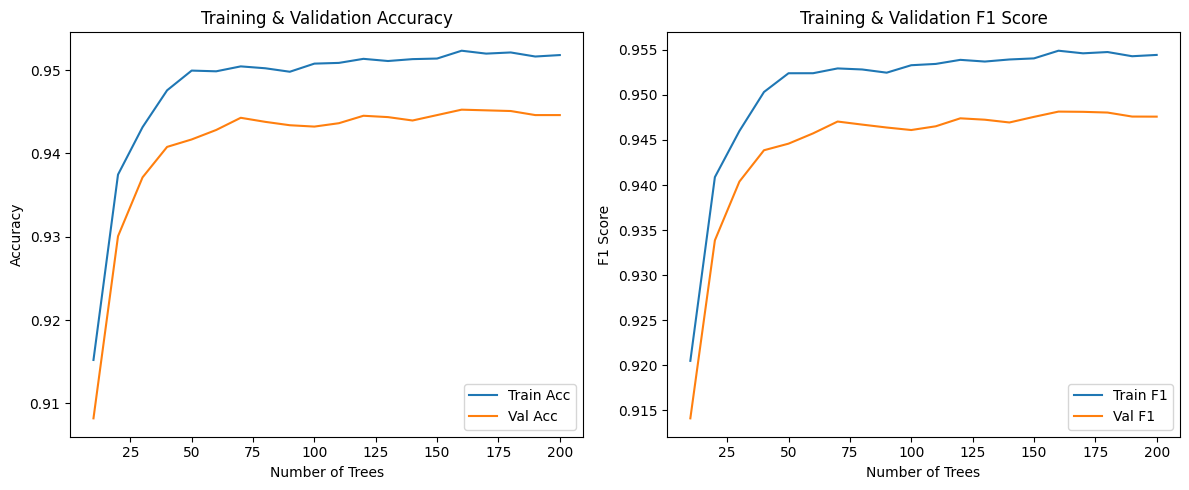

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize Random Forest with warm_start=True for iterative training
rf = RandomForestClassifier(
    n_estimators=10,       # start with small number
    max_depth=15,          # control overfitting
    min_samples_split=10,  # prevent splits on very few samples
    min_samples_leaf=5,    # leaf size regularization
    class_weight='balanced',
    random_state=42,
    warm_start=True,       # allows incremental growth
    n_jobs=-1
)

# Lists to store metrics
train_acc_list, val_acc_list = [], []
train_f1_list, val_f1_list = [], []

# Incrementally grow forest to 200 trees
for n in range(10, 201, 10):
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    # Training metrics
    y_train_pred = rf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)

    # Validation metrics
    y_val_pred = rf.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    # Store
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    print(f"n_estimators={n} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

# Plot accuracy and F1 over iterations
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(10,201,10), train_acc_list, label='Train Acc')
plt.plot(range(10,201,10), val_acc_list, label='Val Acc')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(10,201,10), train_f1_list, label='Train F1')
plt.plot(range(10,201,10), val_f1_list, label='Val F1')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title('Training & Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


## Train FINAL model using Train + Validation

In [25]:
from scipy.sparse import vstack
from sklearn.ensemble import RandomForestClassifier

# Combine training + validation
X_train_final = vstack([X_train, X_val])
y_train_final = np.concatenate([y_train, y_val])

# Final Random Forest model
final_rf = RandomForestClassifier(
    n_estimators=160,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train final model
final_rf.fit(X_train_final, y_train_final)


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=160, n_jobs=-1, random_state=42)

## model evaluation

In [26]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# Predictions
y_test_pred = final_rf.predict(X_test)
y_test_proba = final_rf.predict_proba(X_test)[:, 1]  # phishing probability

# Metrics
acc = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test Accuracy:", acc)
print("Test ROC-AUC:", roc_auc)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_test_pred))


Test Accuracy: 0.9450129954515919
Test ROC-AUC: 0.9843451036733175

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      5885
           1       0.94      0.96      0.95      6427

    accuracy                           0.95     12312
   macro avg       0.95      0.94      0.94     12312
weighted avg       0.95      0.95      0.94     12312

Confusion Matrix:

[[5457  428]
 [ 249 6178]]


- We use F1-score and Recall because missing a phishing email is more costly than a false alarm (so for us each class matter).

### Save the TF-IDF vectorizer and Random Forest model

In [27]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save Random Forest model
joblib.dump(final_rf, "random_forest_phishing.pkl")

print("Models saved successfully!")


Models saved successfully!


###  Load the models

In [28]:
# # Load TF-IDF
# tfidf_loaded = joblib.load("tfidf_vectorizer.pkl")

# # Load Random Forest
# rf_loaded = joblib.load("random_forest_phishing.pkl")

## Install + set Groq key safely (Colab)

In [48]:
!pip -q install groq joblib

import os
from getpass import getpass


In [49]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API')

In [50]:
import joblib
import numpy as np

tfidf_loaded = joblib.load("tfidf_vectorizer.pkl")
rf_loaded = joblib.load("random_forest_phishing.pkl")

print("Loaded:", type(tfidf_loaded), type(rf_loaded))


Loaded: <class 'sklearn.feature_extraction.text.TfidfVectorizer'> <class 'sklearn.ensemble._forest.RandomForestClassifier'>


## Core utilities (cleaning, risk score, labels)

In [60]:
import re

def clean_text_like_training(text: str) -> str:
    text = (text or "").lower()
    text = re.sub(r"\s+", " ", text)
    # match your training regex: keep a-z0-9 whitespace : / .
    text = re.sub(r"[^a-z0-9\s:/\.]", "", text)
    return text.strip()

def probability_to_risk(prob: float) -> int:
    return int(round(float(prob) * 100))

def risk_label(score: int) -> str:
    if score < 45:
        return "Safe"
    elif score < 70:
        return "Suspicious"
    return "Phishing"


## ML explainability: top contributing TF-IDF terms (local)

In [61]:
def top_influencing_features(text: str, model, vectorizer, top_k: int = 10):
    clean = clean_text_like_training(text)
    X = vectorizer.transform([clean])

    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        return []

    # Convert sparse row to dense for a single sample (ok for 10k features)
    x_dense = X.toarray()[0]
    contrib = x_dense * importances

    top_idx = np.argsort(contrib)[-top_k:][::-1]
    feats = vectorizer.get_feature_names_out()

    out = []
    for i in top_idx:
        if contrib[i] > 0:
            out.append({
                "feature": str(feats[i]),
                "contribution": float(contrib[i])
            })
    return out


## “High impact” detection (finance/HR/executive)

In [62]:
HIGH_IMPACT_KEYWORDS = [
    # finance
    "invoice", "payment", "wire", "bank", "transaction", "payroll", "salary",
    "tax", "refund", "billing", "purchase order", "po",
    # hr / policy
    "hr", "human resources", "compensation", "benefits", "termination",
    "policy update", "disciplinary",
    # exec / authority
    "ceo", "cfo", "cto", "director", "vp", "president", "executive",
    # creds / access
    "password", "login", "mfa", "otp", "verification", "reset",
]

def is_high_impact(text: str) -> bool:
    t = clean_text_like_training(text)
    return any(k in t for k in HIGH_IMPACT_KEYWORDS)


## ML inference function (risk + label + ML reasons)

In [63]:
def ml_assess_email(text: str, model, vectorizer, top_k: int = 8):
    clean = clean_text_like_training(text)
    X = vectorizer.transform([clean])

    proba = float(model.predict_proba(X)[0, 1])
    score = probability_to_risk(proba)
    label = risk_label(score)

    top_signals = top_influencing_features(text, model, vectorizer, top_k=top_k)

    # Simple extra “signals” (optional but useful)
    signals = []
    if any(w in clean for w in ["urgent", "immediately", "act now", "verify", "click", "limited"]):
        signals.append("Urgency language detected")
    if "http" in clean or "www." in clean:
        signals.append("Contains link(s)")
    if "password" in clean or "otp" in clean or "mfa" in clean:
        signals.append("Credential-related terms detected")
    if is_high_impact(text):
        signals.append("High-impact context detected (finance/HR/executive)")

    return {
        "ml_probability": round(proba, 4),
        "risk_score": score,
        "ml_label": label,
        "ml_top_signals": top_signals,
        "ml_additional_signals": signals
    }


## LLM escalation rules (controlled)

In [64]:
def should_escalate_to_llm(risk_score: int, text: str, low: int = 45, high: int = 70) -> bool:
    borderline = (low <= risk_score <= high)
    high_impact = is_high_impact(text)
    return borderline or high_impact


## Groq LLM call (llama-3.1-8b-instant) with strict JSON output

In [65]:
from groq import Groq
import json

client = Groq(api_key=os.environ.get(GROQ_API_KEY))

LLM_SYSTEM = """You are a security email triage assistant.
You must help review borderline/high-impact emails.
Rules:
- Do NOT blindly override the ML classifier.
- Use the provided ML score/signals as strong evidence.
- Output ONLY valid JSON (no markdown, no extra text)."""

def groq_llm_review(email_text: str, ml_result: dict, model_name: str = "llama-3.1-8b-instant"):
    prompt = {
        "email": email_text,
        "ml_result": ml_result,
        "task": {
            "classify": ["Safe", "Suspicious", "Phishing"],
            "return_fields": [
                "llm_label",
                "confidence_0_1",
                "reasons_bullets",
                "non_technical_explanation",
                "user_guidance_bullets",
                "alignment_with_ml"  # one of: "agree", "mild_disagree", "strong_disagree"
            ]
        },
        "constraints": {
            "non_technical_explanation_max_words": 80,
            "reasons_bullets_max": 6,
            "user_guidance_bullets_max": 5
        }
    }

    completion = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": LLM_SYSTEM},
            {"role": "user", "content": json.dumps(prompt)}
        ],
        temperature=0.2,
        max_completion_tokens=700,
        top_p=1,
        stream=False
    )

    text = completion.choices[0].message.content.strip()

    # Robust JSON parse
    try:
        data = json.loads(text)
    except json.JSONDecodeError:
        # fallback: try to extract JSON block if the model adds extra text
        start = text.find("{")
        end = text.rfind("}")
        if start != -1 and end != -1 and end > start:
            data = json.loads(text[start:end+1])
        else:
            raise ValueError("LLM did not return valid JSON.")

    return data


## Final decision logic

In [66]:
def combine_ml_llm(ml_result: dict, llm_result: dict):
    ml_label = ml_result["ml_label"]
    score = ml_result["risk_score"]

    llm_label = llm_result.get("llm_label", "Suspicious")
    alignment = llm_result.get("alignment_with_ml", "agree")

    final_label = ml_label  # default

    if score >= 70:
        final_label = "Phishing"
    elif score < 45:
        final_label = "Safe"
        # allow override only if high-impact and strong disagreement
        if "High-impact context detected (finance/HR/executive)" in ml_result.get("ml_additional_signals", []) and alignment == "strong_disagree":
            final_label = llm_label
    else:
        # suspicious band: allow one-step adjustment
        if ml_label == "Suspicious":
            if llm_label in ["Safe", "Phishing"]:
                final_label = llm_label
        else:
            final_label = ml_label  # for completeness

    return final_label


## One function: full scanner (ML + conditional LLM + explanation)

In [67]:
def scan_email(email_text: str, model, vectorizer):
    ml = ml_assess_email(email_text, model, vectorizer)

    result = {
        "final_verdict": ml["ml_label"],
        "risk_score": ml["risk_score"],
        "ml_analysis": ml,
        "llm_review_used": False,
        "llm_review": None,
        "user_explanation": None,
        "user_guidance": None
    }

    if should_escalate_to_llm(ml["risk_score"], email_text):
        llm = groq_llm_review(email_text, ml)
        result["llm_review_used"] = True
        result["llm_review"] = llm

        final_verdict = combine_ml_llm(ml, llm)
        result["final_verdict"] = final_verdict

        # Non-technical explanation & guidance come from LLM if present
        result["user_explanation"] = llm.get("non_technical_explanation")
        result["user_guidance"] = llm.get("user_guidance_bullets")
    else:
        # Provide a simple non-technical explanation without LLM
        signals = ml["ml_additional_signals"][:3]
        top_terms = [s["feature"] for s in ml["ml_top_signals"][:5]]
        result["user_explanation"] = (
            f"This email looks {result['final_verdict'].lower()} based on patterns seen in known phishing emails. "
            f"Key signals: {', '.join(signals) if signals else 'text patterns in the message'}. "
            f"Top terms: {', '.join(top_terms) if top_terms else 'N/A'}."
        )
        if result["final_verdict"] == "Phishing":
            result["user_guidance"] = [
                "Do not click links or open attachments.",
                "Do not reply with personal or login information.",
                "Report this email to IT/security."
            ]
        elif result["final_verdict"] == "Suspicious":
            result["user_guidance"] = [
                "Do not click links yet.",
                "Verify the sender using a trusted channel (call/official website).",
                "If unsure, report to IT/security."
            ]
        else:
            result["user_guidance"] = [
                "No action needed.",
                "If anything feels off, verify the sender."
            ]

    return result


## 3 example analyses (Deliverable requirement)

In [68]:
examples = [
    {
        "name": "Example 1 (clear phishing)",
        "text": "URGENT: Your mailbox will be suspended. Verify your password immediately: http://mail-security-check.example/login"
    },
    {
        "name": "Example 2 (borderline / needs LLM)",
        "text": "Hi, please review the attached invoice for last month and confirm if we should proceed with payment today. Thanks."
    },
    {
        "name": "Example 3 (safe-ish internal note)",
        "text": "Team, reminder: standup moved to 10:30 AM tomorrow. No action needed unless you can’t attend."
    }
]

for ex in examples:
    out = scan_email(ex["text"], rf_loaded, tfidf_loaded)
    print("\n" + "="*80)
    print(ex["name"])
    print(f"Final Verdict: {out['final_verdict']}")
    print(f"Risk Score: {out['risk_score']}")
    print("\nML Analysis signals:")
    for s in out["ml_analysis"]["ml_additional_signals"]:
        print("•", s)
    print("\nTop ML terms:")
    for s in out["ml_analysis"]["ml_top_signals"][:6]:
        print(f"• {s['feature']} ({s['contribution']:.6f})")

    if out["llm_review_used"]:
        print("\nLLM Review:")
        print("Label:", out["llm_review"].get("llm_label"))
        print("Alignment:", out["llm_review"].get("alignment_with_ml"))
        for r in out["llm_review"].get("reasons_bullets", [])[:6]:
            print("•", r)

    print("\nUser Explanation:")
    print(out["user_explanation"])
    print("\nUser Guidance:")
    if out["user_guidance"]:
        for g in out["user_guidance"]:
            print("•", g)
    else:
        print("• No specific user guidance provided.")


Example 1 (clear phishing)
Final Verdict: Suspicious
Risk Score: 56

ML Analysis signals:
• Urgency language detected
• Contains link(s)
• Credential-related terms detected
• High-impact context detected (finance/HR/executive)

Top ML terms:
• http (0.000799)
• urgent (0.000330)
• example (0.000224)
• immediately (0.000040)
• verify (0.000018)
• mailbox (0.000008)

LLM Review:
Label: None
Alignment: The machine learning model has identified this email as suspicious with a confidence level of 55.87%
• The email contains a link to a login page, which could be a phishing attempt.
• The email uses urgency language to try to prompt the user into taking action quickly.
• The email contains terms related to credentials and account suspension, which could be a phishing attempt.

User Explanation:
This email appears to be a phishing attempt because it uses urgency language and contains a link to a login page. It also contains terms related to credentials and account suspension, which could be 

# FINAL  PROPER Explainability

In [69]:
!pip -q install groq joblib

import os
from google.colab import userdata

# Get API key from Colab secrets
GROQ_API_KEY = userdata.get('GROQ_API')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

import joblib
import numpy as np

# Load models
tfidf_loaded = joblib.load("tfidf_vectorizer.pkl")
rf_loaded = joblib.load("random_forest_phishing.pkl")

print("✓ Models loaded successfully:", type(tfidf_loaded), type(rf_loaded))


## Core utilities (cleaning, risk score, labels)

import re

def clean_text_like_training(text: str) -> str:
    """Clean text exactly like training data preprocessing"""
    text = (text or "").lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-z0-9\s:/\.]", "", text)
    return text.strip()

def probability_to_risk(prob: float) -> int:
    """Convert probability to risk score (0-100)"""
    return int(round(float(prob) * 100))

def risk_label(score: int) -> str:
    """Assign label based on risk score"""
    if score < 45:
        return "Safe"
    elif score < 70:
        return "Suspicious"
    return "Phishing"


## ML explainability: top contributing TF-IDF terms

def top_influencing_features(text: str, model, vectorizer, top_k: int = 10):
    """Extract top features contributing to classification"""
    clean = clean_text_like_training(text)
    X = vectorizer.transform([clean])

    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        return []

    x_dense = X.toarray()[0]
    contrib = x_dense * importances

    top_idx = np.argsort(contrib)[-top_k:][::-1]
    feats = vectorizer.get_feature_names_out()

    out = []
    for i in top_idx:
        if contrib[i] > 0:
            out.append({
                "feature": str(feats[i]),
                "contribution": float(contrib[i])
            })
    return out


## High-impact email detection

HIGH_IMPACT_KEYWORDS = [
    # finance
    "invoice", "payment", "wire", "bank", "transaction", "payroll", "salary",
    "tax", "refund", "billing", "purchase order", "po", "account",
    # hr / policy
    "hr", "human resources", "compensation", "benefits", "termination",
    "policy update", "disciplinary",
    # exec / authority
    "ceo", "cfo", "cto", "director", "vp", "president", "executive",
    # credentials / access
    "password", "login", "mfa", "otp", "verification", "reset", "verify",
]

def is_high_impact(text: str) -> bool:
    """Check if email contains high-impact keywords"""
    t = clean_text_like_training(text)
    return any(k in t for k in HIGH_IMPACT_KEYWORDS)


## ML inference function

def ml_assess_email(text: str, model, vectorizer, top_k: int = 8):
    """Perform ML assessment and extract signals"""
    clean = clean_text_like_training(text)
    X = vectorizer.transform([clean])

    proba = float(model.predict_proba(X)[0, 1])
    score = probability_to_risk(proba)
    label = risk_label(score)

    top_signals = top_influencing_features(text, model, vectorizer, top_k=top_k)

    # Additional signal detection
    signals = []
    if any(w in clean for w in ["urgent", "immediately", "act now", "verify", "click", "limited"]):
        signals.append("Urgency language detected")
    if "http" in clean or "www." in clean:
        signals.append("Contains link(s)")
    if any(w in clean for w in ["password", "otp", "mfa", "login", "verify"]):
        signals.append("Credential-related terms detected")
    if is_high_impact(text):
        signals.append("High-impact context (finance/HR/executive)")

    return {
        "ml_probability": round(proba, 4),
        "risk_score": score,
        "ml_label": label,
        "ml_top_signals": top_signals,
        "ml_additional_signals": signals
    }


## LLM escalation rules

def should_escalate_to_llm(risk_score: int, text: str, low: int = 45, high: int = 70) -> bool:
    """Determine if LLM review is needed"""
    borderline = (low <= risk_score <= high)
    high_impact = is_high_impact(text)
    return borderline or high_impact


## Groq LLM call with structured output

from groq import Groq
import json

client = Groq(api_key=os.environ.get('GROQ_API_KEY'))

LLM_SYSTEM = """You are a security email triage assistant.
You must help review borderline/high-impact emails.
Rules:
- Do NOT blindly override the ML classifier
- Use the provided ML score/signals as strong evidence
- Output ONLY valid JSON (no markdown, no extra text)
- Be concise and clear in explanations"""

def groq_llm_review(email_text: str, ml_result: dict, model_name: str = "llama-3.1-8b-instant"):
    """Get LLM review for borderline/high-impact emails"""

    # Truncate email to avoid token limits
    email_preview = email_text[:800] if len(email_text) > 800 else email_text

    prompt = {
        "email": email_preview,
        "ml_result": {
            "risk_score": ml_result["risk_score"],
            "ml_label": ml_result["ml_label"],
            "signals": ml_result["ml_additional_signals"]
        },
        "task": {
            "classify_as": ["Safe", "Suspicious", "Phishing"],
            "return_json_with": [
                "llm_label (one of: Safe, Suspicious, Phishing)",
                "confidence_0_1 (float between 0 and 1)",
                "reasons_bullets (list of 3-5 brief points)",
                "non_technical_explanation (max 60 words)",
                "user_guidance_bullets (list of 3-4 action items)",
                "alignment_with_ml (one of: agree, mild_disagree, strong_disagree)"
            ]
        }
    }

    try:
        completion = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": LLM_SYSTEM},
                {"role": "user", "content": json.dumps(prompt, indent=2)}
            ],
            temperature=0.2,
            max_completion_tokens=700,
            top_p=1,
            stream=False
        )

        text = completion.choices[0].message.content.strip()

        # Robust JSON extraction
        try:
            data = json.loads(text)
        except json.JSONDecodeError:
            # Try to extract JSON block
            start = text.find("{")
            end = text.rfind("}")
            if start != -1 and end != -1 and end > start:
                data = json.loads(text[start:end+1])
            else:
                # Fallback response
                data = {
                    "llm_label": ml_result["ml_label"],
                    "confidence_0_1": 0.5,
                    "reasons_bullets": ["LLM parsing error - using ML assessment"],
                    "non_technical_explanation": "Analysis based on ML patterns only",
                    "user_guidance_bullets": ["Verify sender", "Exercise caution"],
                    "alignment_with_ml": "agree"
                }

        return data

    except Exception as e:
        print(f"⚠ LLM Error: {e}")
        # Return fallback
        return {
            "llm_label": ml_result["ml_label"],
            "confidence_0_1": 0.5,
            "reasons_bullets": [f"LLM unavailable: {str(e)[:50]}"],
            "non_technical_explanation": "Using ML-only assessment due to LLM error",
            "user_guidance_bullets": ["Verify sender through official channels", "Exercise caution"],
            "alignment_with_ml": "agree"
        }


## Final decision logic

def combine_ml_llm(ml_result: dict, llm_result: dict):
    """Combine ML and LLM predictions with controlled override"""
    ml_label = ml_result["ml_label"]
    score = ml_result["risk_score"]

    llm_label = llm_result.get("llm_label", "Suspicious")
    alignment = llm_result.get("alignment_with_ml", "agree")

    final_label = ml_label

    # Strong ML signals take priority
    if score >= 70:
        final_label = "Phishing"
    elif score < 45:
        final_label = "Safe"
        # Allow override only for high-impact + strong disagreement
        if is_high_impact(ml_result.get("email_text", "")) and alignment == "strong_disagree":
            final_label = llm_label
    else:
        # Suspicious band: allow LLM refinement
        if ml_label == "Suspicious":
            if llm_label in ["Safe", "Phishing"] and alignment != "strong_disagree":
                final_label = llm_label

    return final_label


## Main scanner function

def scan_email(email_text: str, model, vectorizer):
    """
    Full email scanner: ML + conditional LLM + explanation
    """
    # Step 1: ML assessment
    ml = ml_assess_email(email_text, model, vectorizer)
    ml["email_text"] = email_text  # store for later use

    result = {
        "final_verdict": ml["ml_label"],
        "risk_score": ml["risk_score"],
        "ml_analysis": ml,
        "llm_review_used": False,
        "llm_review": None,
        "user_explanation": None,
        "user_guidance": None
    }

    # Step 2: Check if LLM escalation needed
    if should_escalate_to_llm(ml["risk_score"], email_text):
        llm = groq_llm_review(email_text, ml)
        result["llm_review_used"] = True
        result["llm_review"] = llm

        # Step 3: Combine ML + LLM
        final_verdict = combine_ml_llm(ml, llm)
        result["final_verdict"] = final_verdict

        # Use LLM explanation & guidance
        result["user_explanation"] = llm.get("non_technical_explanation")
        result["user_guidance"] = llm.get("user_guidance_bullets", [])
    else:
        # Generate simple explanation without LLM
        signals = ml["ml_additional_signals"][:3]
        top_terms = [s["feature"] for s in ml["ml_top_signals"][:5]]

        result["user_explanation"] = (
            f"This email appears {result['final_verdict'].lower()} based on patterns in known emails. "
            f"Key signals: {', '.join(signals) if signals else 'text patterns'}."
        )

        # Guidance based on verdict
        if result["final_verdict"] == "Phishing":
            result["user_guidance"] = [
                "Do not click links or open attachments",
                "Do not reply with personal or login information",
                "Report this email to IT/security immediately"
            ]
        elif result["final_verdict"] == "Suspicious":
            result["user_guidance"] = [
                "Do not click links yet",
                "Verify the sender using a trusted channel",
                "If unsure, report to IT/security"
            ]
        else:
            result["user_guidance"] = [
                "Email appears safe, proceed normally",
                "If anything feels off, verify the sender"
            ]

    return result


## Display formatted output

def display_result(result: dict, example_name: str = ""):
    """Pretty print scanner results"""
    print("\n" + "="*70)
    if example_name:
        print(f"📧 {example_name}")
    print("="*70)
    print(f"FINAL VERDICT: {result['final_verdict']}")
    print(f"RISK SCORE: {result['risk_score']}%")
    print("="*70)

    print("\n📊 ML ANALYSIS:")
    ml = result['ml_analysis']
    print(f"  ML Label: {ml['ml_label']} (probability: {ml['ml_probability']})")

    if ml['ml_additional_signals']:
        print("\n  Key Signals:")
        for s in ml['ml_additional_signals']:
            print(f"    • {s}")

    if ml['ml_top_signals']:
        print("\n  Top Contributing Features:")
        for s in ml['ml_top_signals'][:6]:
            print(f"    • {s['feature']} (weight: {s['contribution']:.6f})")

    if result['llm_review_used']:
        print("\n🤖 LLM REVIEW:")
        llm = result['llm_review']
        print(f"  LLM Label: {llm.get('llm_label', 'N/A')}")
        print(f"  Confidence: {llm.get('confidence_0_1', 0):.2f}")
        print(f"  Alignment with ML: {llm.get('alignment_with_ml', 'N/A')}")

        if llm.get('reasons_bullets'):
            print("\n  Reasoning:")
            for r in llm['reasons_bullets']:
                print(f"    • {r}")

    print("\n💡 USER EXPLANATION:")
    print(f"  {result['user_explanation']}")

    print("\n✅ USER GUIDANCE:")
    if result['user_guidance']:
        for g in result['user_guidance']:
            print(f"  • {g}")

    print("="*70)


## Example analyses (3 required examples)

print("\n" + "🔍 PHISHING EMAIL SCANNER - EXAMPLE ANALYSES".center(70))

examples = [
    {
        "name": "Example 1: Clear Phishing (High Risk)",
        "text": "URGENT: Your mailbox will be suspended in 24 hours! Verify your password immediately by clicking here: http://mail-security-check.example/login?user=verify"
    },
    {
        "name": "Example 2: Borderline Case (Needs LLM)",
        "text": "Hi, please review the attached invoice for last month's services and confirm if we should proceed with the payment today. The total amount is $4,500. Let me know if you have any questions. Thanks, Finance Team"
    },
    {
        "name": "Example 3: Safe Internal Email",
        "text": "Team, quick reminder that our standup meeting has been moved to 10:30 AM tomorrow instead of 10:00 AM. No action needed unless you have a conflict. See you all then!"
    }
]

for ex in examples:
    out = scan_email(ex["text"], rf_loaded, tfidf_loaded)
    display_result(out, ex["name"])


## Test on actual dataset samples

print("\n\n" + "📧 TESTING ON DATASET SAMPLES".center(70))
print("="*70)

# Test 1: Random safe email from dataset
print("\n🔵 TEST 1: Random Safe Email from Dataset")
safe_sample = df_1[df_1['label'] == 0].sample(1, random_state=123)['clean_text'].iloc[0]
result_safe = scan_email(safe_sample, rf_loaded, tfidf_loaded)
display_result(result_safe)

# Test 2: Random phishing email from dataset
print("\n🔴 TEST 2: Random Phishing Email from Dataset")
phish_sample = df_1[df_1['label'] == 1].sample(1, random_state=456)['clean_text'].iloc[0]
result_phish = scan_email(phish_sample, rf_loaded, tfidf_loaded)
display_result(result_phish)


## Evaluation metrics

print("\n\n" + "📈 SYSTEM EVALUATION".center(70))
print("="*70)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate on a sample to avoid excessive API calls
sample_size = 50
test_sample_indices = np.random.choice(len(y_test), min(sample_size, len(y_test)), replace=False)

predictions = []
true_labels = []
llm_usage_count = 0

print(f"\nEvaluating on {len(test_sample_indices)} test samples...")

for i, idx in enumerate(test_sample_indices):
    email = df_1.iloc[y_test.index[idx]]['clean_text']
    true_label = y_test.iloc[idx]

    result = scan_email(email, rf_loaded, tfidf_loaded)

    # Convert verdict to binary
    pred = 1 if result['final_verdict'] in ['Phishing', 'Suspicious'] else 0
    predictions.append(pred)
    true_labels.append(true_label)

    if result['llm_review_used']:
        llm_usage_count += 1

    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(test_sample_indices)} emails...")

print("\n" + "-"*70)
print("METRICS:")
print(f"  Accuracy:  {accuracy_score(true_labels, predictions):.4f}")
print(f"  Precision: {precision_score(true_labels, predictions):.4f}")
print(f"  Recall:    {recall_score(true_labels, predictions):.4f}")
print(f"  F1-Score:  {f1_score(true_labels, predictions):.4f}")
print(f"\n  LLM Usage: {llm_usage_count}/{len(test_sample_indices)} emails ({llm_usage_count/len(test_sample_indices)*100:.1f}%)")
print("="*70)

print("\n✅ Scanner system ready for deployment!")

✓ Models loaded successfully: <class 'sklearn.feature_extraction.text.TfidfVectorizer'> <class 'sklearn.ensemble._forest.RandomForestClassifier'>

             🔍 PHISHING EMAIL SCANNER - EXAMPLE ANALYSES              

📧 Example 1: Clear Phishing (High Risk)
FINAL VERDICT: Suspicious
RISK SCORE: 56%

📊 ML ANALYSIS:
  ML Label: Suspicious (probability: 0.5587)

  Key Signals:
    • Urgency language detected
    • Contains link(s)
    • Credential-related terms detected
    • High-impact context (finance/HR/executive)

  Top Contributing Features:
    • http (weight: 0.000709)
    • urgent (weight: 0.000293)
    • example (weight: 0.000198)
    • immediately (weight: 0.000035)
    • hours (weight: 0.000025)
    • verify (weight: 0.000016)

🤖 LLM REVIEW:
  LLM Label: Suspicious
  Confidence: 0.80
  Alignment with ML: agree

  Reasoning:
    • The email contains urgency language, which is often used in phishing attacks.
    • The email contains a link that may lead to a malicious website.
